In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

In [4]:
#importing total X_train(features)
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X.csv')

In [5]:
#importing total Y_train(target)
y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y.csv')

In [6]:
#splitting train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
#model building and fitting
catboost_clf = CatBoostClassifier()
catboost_clf.fit(X_train, y_train)

Learning rate set to 0.15124
0:	learn: 0.5698690	total: 1.16s	remaining: 19m 16s
1:	learn: 0.4889574	total: 2.07s	remaining: 17m 13s
2:	learn: 0.4338343	total: 3.3s	remaining: 18m 15s
3:	learn: 0.3981495	total: 4.5s	remaining: 18m 39s
4:	learn: 0.3739085	total: 5.65s	remaining: 18m 45s
5:	learn: 0.3567202	total: 6.86s	remaining: 18m 57s
6:	learn: 0.3440750	total: 8.31s	remaining: 19m 38s
7:	learn: 0.3352766	total: 10.1s	remaining: 20m 47s
8:	learn: 0.3285618	total: 12s	remaining: 22m 1s
9:	learn: 0.3242618	total: 13.6s	remaining: 22m 29s
10:	learn: 0.3209362	total: 15.5s	remaining: 23m 11s
11:	learn: 0.3182404	total: 17.2s	remaining: 23m 39s
12:	learn: 0.3163149	total: 19s	remaining: 23m 58s
13:	learn: 0.3148334	total: 20.5s	remaining: 24m 2s
14:	learn: 0.3133706	total: 22.6s	remaining: 24m 47s
15:	learn: 0.3123137	total: 24.6s	remaining: 25m 14s
16:	learn: 0.3115678	total: 26.5s	remaining: 25m 32s
17:	learn: 0.3108354	total: 28.1s	remaining: 25m 35s
18:	learn: 0.3102011	total: 29.8s	r

In [8]:
#train accuracy
catboost_clf.score(X_train, y_train)

0.9048203703703703

In [9]:
del X_train, y_train

In [10]:
#test accuracy
yPred = catboost_clf.predict(X_test)
catboost_clf.score(X_test, y_test)

0.8912444444444444

In [11]:
#various performance scores
acc = accuracy_score(y_test, yPred)
print("The accuracy is {}".format(acc))
  
prec = precision_score(y_test, yPred)
print("The precision is {}".format(prec))
  
rec = recall_score(y_test, yPred)
print("The recall is {}".format(rec))
  
f1 = f1_score(y_test, yPred)
print("The F1-Score is {}".format(f1))
  
MCC = matthews_corrcoef(y_test, yPred)
print("The Matthews correlation coefficient is{}".format(MCC))

The accuracy is 0.8912444444444444
The precision is 0.5534253578732107
The recall is 0.10828248474542362
The F1-Score is 0.18112607713544718
The Matthews correlation coefficient is0.20982282282071682


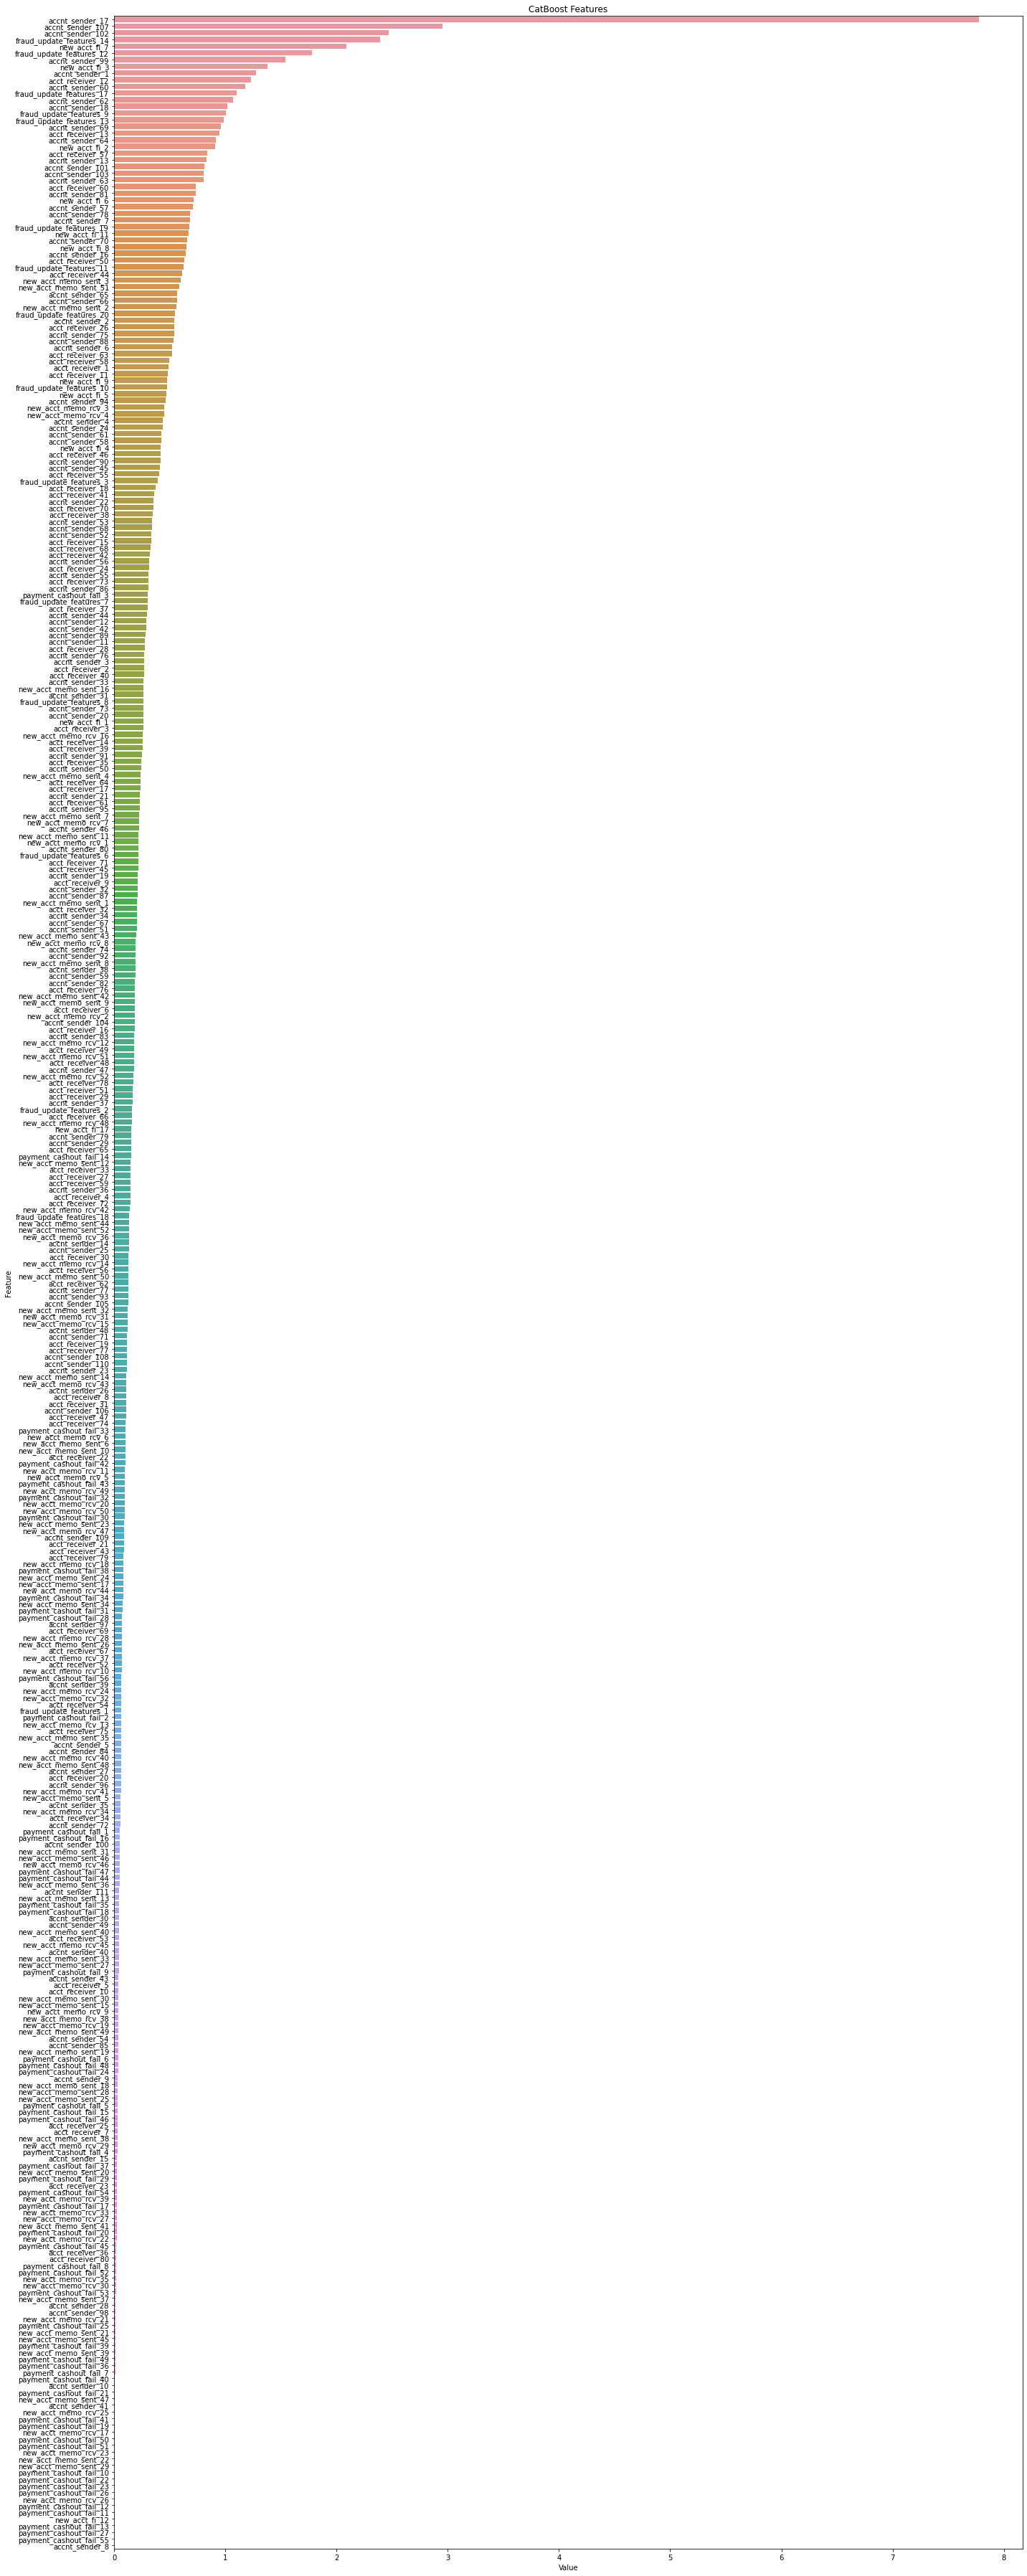

In [12]:
feature_imp = pd.DataFrame(sorted(zip(catboost_clf.feature_importances_,X.columns)), columns=['Value','Feature'])
feature_imp.sort_values(by="Value", ascending=False,inplace=True)
plt.figure(figsize=(20, 50))
sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.title('CatBoost Features')
plt.tight_layout()
plt.show()

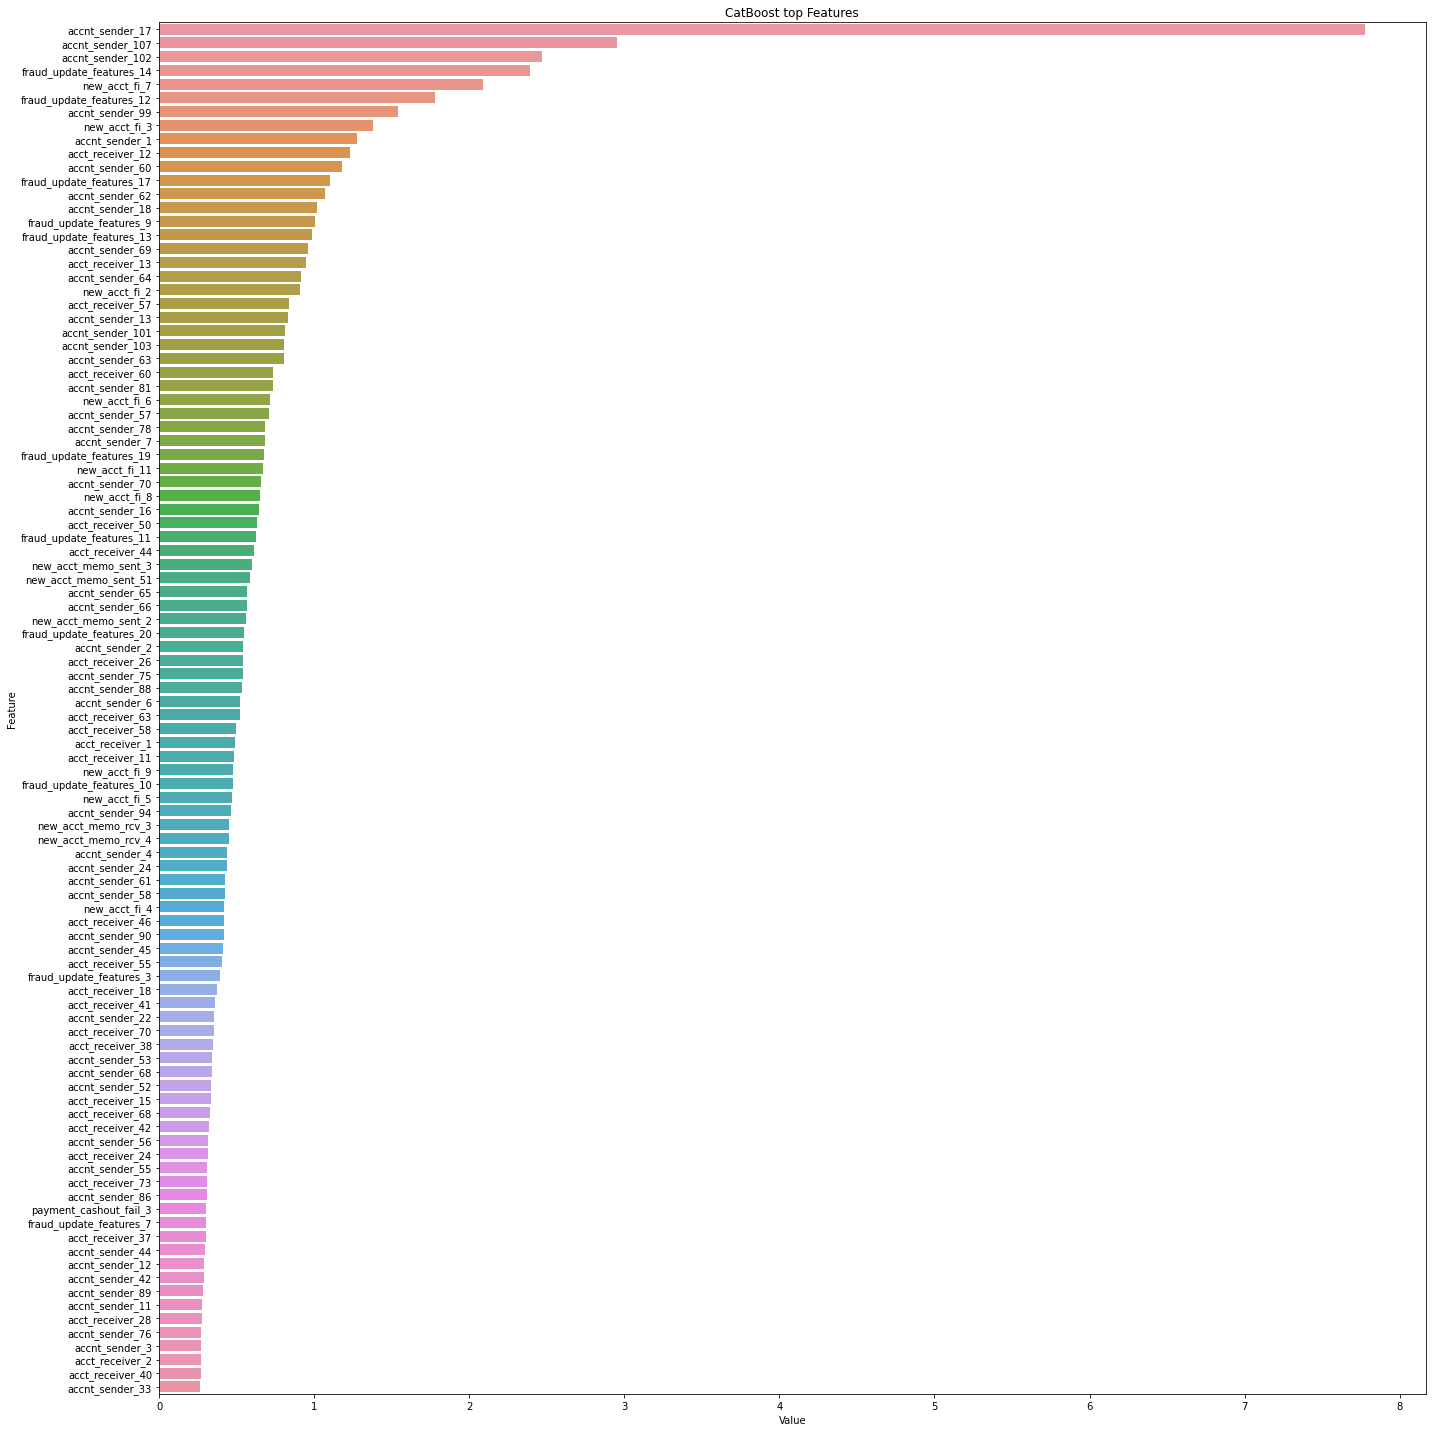

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [20]:
feature_imp_top100= feature_imp.iloc[:100]
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp_top100)
plt.title('CatBoost top Features')
plt.tight_layout()
plt.show()
plt.savefig('catboost_importances.png')
from google.colab import files
files.download('catboost_importances.png')

In [14]:
#ks score function
def ks_(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100
    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    return 

In [15]:
#creating data frame to check ks score for validation data
ks=pd.DataFrame(catboost_clf.predict_proba(X_test))
del ks[0]

In [16]:
y_test.reset_index(inplace=True)
ks['target']=y_test['target']

#ks table
ks_(ks,'target',1)

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.235391  0.982704  6850.0    11150.0     34.26%         6.97%   
2       0.146218  0.235386  3501.0    14499.0     17.51%         9.06%   
3       0.107517  0.146215  2349.0    15651.0     11.75%         9.78%   
4       0.084885  0.107517  1803.0    16197.0      9.02%        10.12%   
5       0.070220  0.084884  1467.0    16533.0      7.34%        10.33%   
6       0.059715  0.070219  1193.0    16807.0      5.97%        10.50%   
7       0.050988  0.059713   949.0    17051.0      4.75%        10.66%   
8       0.042863  0.050987   770.0    17230.0      3.85%        10.77%   
9       0.033907  0.042862   617.0    17383.0      3.09%        10.86%   
10      0.003762  0.033905   495.0    17505.0      2.48%        10.94%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             34.26

In [17]:
#creating data frame of cust ids with probabilities
X_t= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_t.csv')
test_cust= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_cust.csv')
result_model = pd.DataFrame(catboost_clf.predict_proba(X_t))
result=pd.concat([test_cust['cust_id'],result_model[1] ], axis=1)
result.rename(columns={1:'target'},inplace=True)

In [18]:
result

,cust_id,target
0,10146566,0.136088
1,10203613,0.052661
2,10322129,0.018467
3,10373212,0.077929
4,10487539,0.058771
...,...,...
179995,45739460,0.030678
179996,56006782,0.023771
179997,61138340,0.045309
179998,65715392,0.026614


In [19]:
#uploading results(probabilities)
#result.to_csv('/content/drive/MyDrive/Colab Notebooks/results.csv',index=False)